# Job Title Classification for Organizational Role Segmentation

### Introduction

This notebook presents an exploratory data analysis (EDA) and machine learning approach to solve a crucial marketing challenge: automatically classifying job titles according to the Job Level Hierarchy/Organizational Role Segmentation.

### Why is this important?

Accurate classification of organizational roles is invaluable for marketing strategies:

1. **Targeted Communication**: Tailor messages based on decision-making power and responsibilities.
2. **Product Positioning**: Market specific products to appropriate organizational levels.
3. **Lead Qualification**: Identify key decision-makers in B2B marketing efforts.
4. **Content Strategy**: Create content addressing the needs of each job level.
5. **Account-Based Marketing (ABM)**: Map out target organization structures.
6. **Value Proposition Alignment**: Align marketing messages with level-specific priorities and pain points.
7. **Event Planning**: Organize tailored events for specific job levels.
8. **Sales Enablement**: Provide insights for approaching different organizational levels.

### Notebook Overview

This notebook walks through the following steps:
1. Data preprocessing
2. Model and architecture selection
3. Training and testing the model
4. Interpreting results

## Data preprocessing

In [255]:
!pip install lazypredict

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [257]:
RUN_LAZYPREDICT=False
RUN_HYPERPARAM_TUNING=False

In [258]:
df = pd.read_excel('./JobLevelData.xlsx')
display(df.head())
display(df.info())
display(df.describe())


,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     2240 non-null   object
 1   Column 1  2230 non-null   object
 2   Column 2  133 non-null    object
 3   Column 3  12 non-null     object
 4   Column 4  11 non-null     object
dtypes: object(5)
memory usage: 87.6+ KB


None

,Title,Column 1,Column 2,Column 3,Column 4
count,2240,2230,133,12,11
unique,2240,6,4,2,1
top,Vice President / Director of Systems Engineering,Individual Contributor/Staff,Individual Contributor/Staff,Individual Contributor/Staff,Director
freq,1,1039,55,11,11


In [259]:
unique_values = set()

for column in ['Column 1', 'Column 2', 'Column 3', 'Column 4']:
    values = df[column].dropna().unique().tolist()
    unique_values.update(values)

print(f"\nUnique values across all columns:")
print(f"Number of unique values: {len(unique_values)}")
print("Unique values:")
print(list(unique_values))


Unique values across all columns:
Number of unique values: 6
Unique values:
['Individual Contributor/Staff', 'Vice President', 'Chief Officer', 'Owner', 'Manager', 'Director']


In [260]:
display(df[df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].isna().all(axis=1)])

,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Informati...",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscri...,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Cust...,NaN,NaN,NaN,NaN


In [261]:
# manualy input some missing values based on the job title and internet research

df.loc[29, 'Column 1'] = 'Chief Officer'                        # CINO
df.loc[829, 'Column 1'] = 'Individual Contributor/Staff'        # Release of Information Tech II
df.loc[1406, 'Column 1'] = 'Manager'                            # Global People Systems, Processes and Information Manager
df.loc[1713, 'Column 1'] = 'Individual Contributor/Staff'       # Supplier Quality Enginee
df.loc[1785, 'Column 1'] = 'Manager'                            # RC Environmental and Cyber Specialized Subscription Manager
df.loc[2182, 'Column 1'] = 'Director'                           # Senior IndependeDirector and Chair of the Customer and Communities Network
df.loc[2182, 'Title'] = 'Senior Independent Director and Chair of the Customer and Communities Network'        # Senior IndependeDirector and Chair of the Customer and Communities Network


In [262]:
display(df[df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].isna().all(axis=1)])

,Title,Column 1,Column 2,Column 3,Column 4
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN


### Processing the target variables

To prepare these labels for classification, we will use one-hot encoding. This process will create 6 binary columns, one for each unique label.


In [263]:
# One hot encoding
columns_to_encode = ['Column 1', 'Column 2', 'Column 3', 'Column 4']

one_hot_encoded = pd.DataFrame()

for value in unique_values:
    one_hot_encoded[f'Label_{value}'] = df[columns_to_encode].eq(value).any(axis=1).astype(int)

df = pd.concat([df['Title'], one_hot_encoded], axis=1)
display(df.head())

,Title,Label_Individual Contributor/Staff,Label_Vice President,Label_Chief Officer,Label_Owner,Label_Manager,Label_Director
0,Vice President / Director of Systems Engineering,0,1,0,0,0,0
1,Systems Engineer; Systems Architect,1,0,0,0,1,0
2,"Executive Director, Global IT Infrastructure /...",0,0,1,0,0,1
3,CTO/Executive Director of Technology Services,0,0,1,0,0,1
4,"Vice President, CIO",0,1,0,0,0,0


Distribution of labels across all columns:
Label_Individual Contributor/Staff: 1107 (49.42%)
Label_Director: 498 (22.23%)
Label_Vice President: 403 (17.99%)
Label_Manager: 213 (9.51%)
Label_Chief Officer: 167 (7.46%)
Label_Owner: 4 (0.18%)


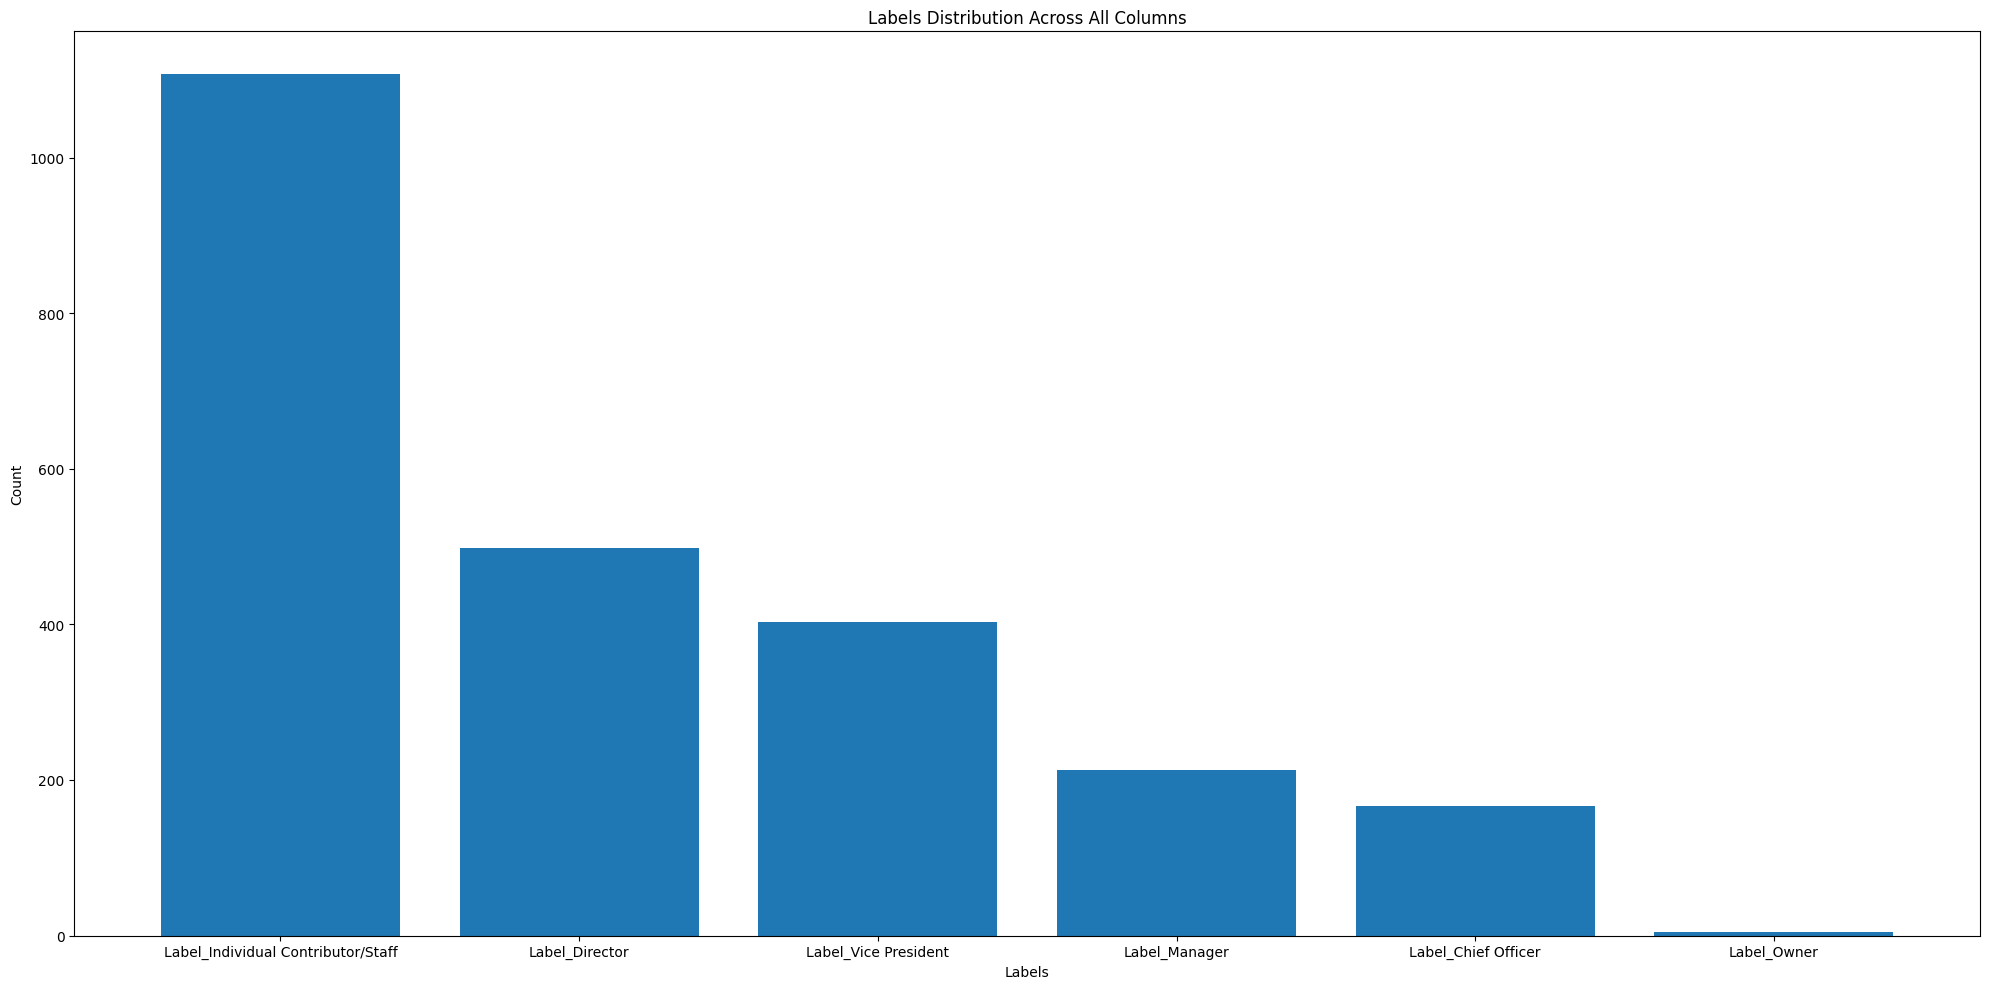

In [264]:
label_distribution = {}

for column in unique_values:
    count = df['Label_' + column].sum()
    label_distribution['Label_' + column] = count

# Sort the distribution by count in descending order
sorted_distribution = sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)

total_count = df.shape[0]
print("Distribution of labels across all columns:")
for label, count in sorted_distribution:
    percentage = (count / total_count) * 100
    print(f"{label}: {count} ({percentage:.2f}%)")

# Visualize all labels
sorted_distribution = dict(sorted_distribution)
plt.figure(figsize=(20, 10))  # Increased figure size to accommodate all labels
plt.bar(sorted_distribution.keys(), sorted_distribution.values())
plt.title("Labels Distribution Across All Columns")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Label Distribution Analysis

The distribution of labels across all columns reflects a typical organizational structure, with a large base of individual contributors and progressively fewer positions at higher levels of management.

### Data Imbalance Issue:
The Owner category is significantly underrepresented with only 4 instances (0.18%) in the entire dataset. This extreme imbalance could lead to poor model performance in identifying and classifying Owner roles.

To address the data imbalance, particularly for the Owner category, it would be valuable to expand the dataset by manually searching for additional job descriptions that fall into this category. This effort would help balance the dataset and potentially improve model performance, especially for identifying the Owner class.


### Data Preprocessing Steps

The following operations were performed during the data preprocessing phase:

1. Convert all text to lowercase
2. Remove special characters and numbers
3. Remove double spaces
4. Delete stop words (except for "IT" as it's an industry name)
5. Normalize titles:
   - Check for misspellings and correct them
   - Convert short forms of words into full words
   - Convert abbreviations into full titles

These steps were applied to clean and standardize the job title data, preparing it for further analysis and model training.

In [265]:
import re
import nltk
from nltk.corpus import stopwords

# basic preprocessing: lowercase, remove special characters,
# remove all numbers, remove extra spaces
df['Title'] = df['Title'].str.lower()

df['Title'] = df['Title'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
df['Title'] = df['Title'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))

# remove stop words
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
stop_words.remove('it') # it is a stop word but it used a lot in the job titles
df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# normalize the job titles:
# i.e sr -> senior, jr -> junior, vp -> vice president, etc.
job_title_dict = {
    # misspelings
    'vise': 'vice',
    'senoir': 'senior',
    'maneger': 'manager',
    'assistent': 'assistant',
    'supervisr': 'supervisor',
    'analist': 'analyst',
    'enginere': 'engineer',
    'developr': 'developer',
    'programer': 'programmer',
    'acountant': 'accountant',
    'lawer': 'lawyer',
    'docter': 'doctor',
    'analista': 'analyst',
    # short forms
    'dev': 'developer',
    'dev.': 'developer',
    'eng': 'engineer',
    'eng.': 'engineer',
    'engr': 'engineer',
    'engr.': 'engineer',
    # title prefixes 
    'reg': 'regional',
    'reg.': 'regional',
    'assoc': 'associate',
    'assoc.': 'associate',
    'asst': 'assistant',
    'asst.': 'assistant',
    'exec': 'executive',
    'exec.': 'executive',
    'deputy': 'deputy',
    'deputy.': 'deputy',
    'mng': 'managing',
    'mng.': 'managing',
    # expertise level
    'sr': 'senior',
    'sr.': 'senior',
    'snr': 'senior',
    'snr.': 'senior',
    'sen': 'senior',
    'sen.': 'senior',
    'jr': 'junior',
    'jr.': 'junior',
    'jnr': 'junior',
    'jnr.': 'junior',
    'jun': 'junior',
    'jun.': 'junior',
    'mid': 'middle',
    'mid.': 'middle',
    'mdl': 'middle',
    'mdl.': 'middle',
    # vice president
    'vp': 'vice president',
    'svp': 'senior vice president',
    'evp': 'executive vice president',
    'avp': 'assistant vice president',
    'sevp': 'senior executive vice president',
    'gvp': 'group vice president',
    'dvp': 'divisional vice president',
    'rvp': 'regional vice president',
    'cvp': 'corporate vice president',
    'davp': 'deputy assistant vice president',
    'savp': 'senior assistant vice president',
    'mvp': 'managing vice president',
    'arvp': 'associate regional vice president',
    # c level officers
    'cfo': 'chief financial officer',
    'coo': 'chief operating officer',
    'cto': 'chief technology officer',
    'cio': 'chief information officer',
    'chro': 'chief human resources officer',
    'cdo': 'chief data officer',
    'cmo': 'chief marketing officer',
    'cso': 'chief sales officer',
    'cco': 'chief communications officer',
    'cro': 'chief relationship officer',
    # directors
    'dir': 'director',
    'dir.': 'director',
    # managers
    'mgr': 'manager',
    'mgr.': 'manager',
    'mng': 'manager',
    'mng.': 'manager',
    'mngr': 'manager',
    'mngr.': 'manager',
}

# Function to normalize job titles
def normalize_job_title(title):
    words = title.split()
    normalized_words = []
    for word in words:
        normalized_words.append(job_title_dict.get(word, word))
    return ' '.join(normalized_words)

df['Title'] = df['Title'].apply(normalize_job_title)

display(df.head(10))
# df.to_excel('processed_job_titles.xlsx', index=False)



,Title,Label_Individual Contributor/Staff,Label_Vice President,Label_Chief Officer,Label_Owner,Label_Manager,Label_Director
0,vice president director systems engineering,0,1,0,0,0,0
1,systems engineer systems architect,1,0,0,0,1,0
2,executive director global it infrastructure ch...,0,0,1,0,0,1
3,chief technology officer executive director te...,0,0,1,0,0,1
4,vice president chief information officer,0,1,0,0,0,0
5,chief information officer cissp,0,0,1,0,0,0
6,chief information officer platform services,0,0,1,0,0,0
7,chief technology officer head marketing,0,0,1,0,0,0
8,chief information systems officer,0,0,1,0,0,0
9,chief data architect,0,0,1,0,0,0


### Feature Vectorization with Word2Vec

After preprocessing the feature column, the next step is to vectorize the text data using the Word2Vec model from Gensim.

In [266]:
import gensim.downloader as api
from gensim.models import KeyedVectors

word2vec = api.load("word2vec-google-news-300")
# word2vec = api.load("glove-twitter-25")


def create_embedding(title):
    words = title.split()
    word_vectors = [word2vec[word] for word in words if word in word2vec.key_to_index]
    if not word_vectors:
        return np.zeros(word2vec.vector_size)
    return np.mean(word_vectors, axis=0)

df['embedding'] = df['Title'].apply(create_embedding)

display(df.head())


,Title,Label_Individual Contributor/Staff,Label_Vice President,Label_Chief Officer,Label_Owner,Label_Manager,Label_Director,embedding
0,vice president director systems engineering,0,1,0,0,0,0,"[-0.044934083, -0.10429688, 0.10664062, -0.023..."
1,systems engineer systems architect,1,0,0,0,1,0,"[0.061279297, -0.036132812, 0.08505249, -0.025..."
2,executive director global it infrastructure ch...,0,0,1,0,0,1,"[0.012003581, -0.09677315, 0.051801894, -0.108..."
3,chief technology officer executive director te...,0,0,1,0,0,1,"[0.020472934, -0.105163574, 0.09854998, -0.098..."
4,vice president chief information officer,0,1,0,0,0,0,"[0.004138184, -0.12734374, 0.11902466, -0.1625..."


## Model and architecture selection

For this multilabel classification task, we will adopt the following approach:

1. Create 6 separate classifiers, one for each target variable.
2. Generate 6 distinct datasets, each containing:
   - Feature embeddings
   - The corresponding target variable

3. Model Selection:
   - Utilize LazyPredict to obtain metrics for various classification models
   - Choose the best-performing model for each target variable based on these metrics

This strategy allows us to tailor the classification approach for each target variable, potentially improving overall performance compared to a single multilabel classifier.

In [267]:
# Create 6 datasets for each label
datasets = []
sorted_unique_values = list(sorted_distribution.keys())

for column in sorted_unique_values:
    print(column)
    # Create a new dataset with embeddings and the current one-hot encoded column
    dataset = pd.DataFrame(df['embedding'].tolist(), columns=[f'emb_{i}' for i in range(word2vec.vector_size)])
    dataset[column] = df[column]
    
    datasets.append((column, dataset))

# Display information about each dataset
for column, dataset in datasets:
    print(f"\nDataset for {column}:")
    print(f"Shape: {dataset.shape}")
    print(f"Positive samples: {dataset[column].sum()}")
    print(f"Negative samples: {len(dataset) - dataset[column].sum()}")
    print("\nFirst few rows:")
    display(dataset.head(1))

Label_Individual Contributor/Staff
Label_Director
Label_Vice President
Label_Manager
Label_Chief Officer
Label_Owner

Dataset for Label_Individual Contributor/Staff:
Shape: (2240, 301)
Positive samples: 1107
Negative samples: 1133

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Individual Contributor/Staff
0,-0.04,-0.10,0.11,-0.02,-0.11,-0.02,0.11,-0.09,0.04,-0.05,...,0.02,-0.16,0.11,0.05,-0.10,0.08,0.01,0.14,0.11,0



Dataset for Label_Director:
Shape: (2240, 301)
Positive samples: 498
Negative samples: 1742

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Director
0,-0.04,-0.10,0.11,-0.02,-0.11,-0.02,0.11,-0.09,0.04,-0.05,...,0.02,-0.16,0.11,0.05,-0.10,0.08,0.01,0.14,0.11,0



Dataset for Label_Vice President:
Shape: (2240, 301)
Positive samples: 403
Negative samples: 1837

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Vice President
0,-0.04,-0.10,0.11,-0.02,-0.11,-0.02,0.11,-0.09,0.04,-0.05,...,0.02,-0.16,0.11,0.05,-0.10,0.08,0.01,0.14,0.11,1



Dataset for Label_Manager:
Shape: (2240, 301)
Positive samples: 213
Negative samples: 2027

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Manager
0,-0.04,-0.10,0.11,-0.02,-0.11,-0.02,0.11,-0.09,0.04,-0.05,...,0.02,-0.16,0.11,0.05,-0.10,0.08,0.01,0.14,0.11,0



Dataset for Label_Chief Officer:
Shape: (2240, 301)
Positive samples: 167
Negative samples: 2073

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Chief Officer
0,-0.04,-0.10,0.11,-0.02,-0.11,-0.02,0.11,-0.09,0.04,-0.05,...,0.02,-0.16,0.11,0.05,-0.10,0.08,0.01,0.14,0.11,0



Dataset for Label_Owner:
Shape: (2240, 301)
Positive samples: 4
Negative samples: 2236

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Owner
0,-0.04,-0.10,0.11,-0.02,-0.11,-0.02,0.11,-0.09,0.04,-0.05,...,0.02,-0.16,0.11,0.05,-0.10,0.08,0.01,0.14,0.11,0


In [268]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

if RUN_LAZYPREDICT:
    for column, dataset in datasets:
        print(f"\nProcessing dataset for {column}")
        
        X = dataset.drop(column, axis=1)
        y = dataset[column]

        if column == 'Label_Owner':
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize and fit LazyClassifier
        clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
        models, predictions = clf.fit(X_train, X_test, y_train, y_test)

        # Display the results
        print(f"Model performance for {column}:")
        display(models)

        # Plot the results
        plt.figure(figsize=(10, 6))
        models.sort_values(by='Accuracy', ascending=True).plot(kind='barh', y='Accuracy')
        plt.title(f'Model Accuracy Comparison for {column}')
        plt.xlabel('Accuracy')
        plt.tight_layout()
        plt.show()
    

According to LazyPredict, the best models for each label are as follows:

- Label_Individual Contributor/Staff: SVC
- Label_Manager: LinearDiscriminantAnalysis
- Label_Director: SVC
- Label_Vice President: SVC
- Label_Chief Officer: LinearDiscriminantAnalysis
- Label_Owner: LinearDiscriminantAnalysis

Next, we will fine-tune these models to find the best parameters for each.

In [269]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
from sklearn.covariance import LedoitWolf, OAS, MinCovDet, GraphicalLasso
from sklearn.model_selection import StratifiedKFold


models = {
    'Label_Individual Contributor/Staff': SVC(),
    'Label_Manager': LinearDiscriminantAnalysis(),
    'Label_Director': SVC(),
    'Label_Vice President': SVC(),
    'Label_Chief Officer': LinearDiscriminantAnalysis(),
    'Label_Owner': LinearDiscriminantAnalysis()
}

svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4, 5],  # Only relevant for poly kernel
    'coef0': [0.0, 0.1, 0.5, 1.0],  # Relevant for poly and sigmoid kernels
    'shrinking': [True, False],
    'class_weight': [None, 'balanced'],
}

lda_param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto'] + list(np.arange(0.0, 1.01, 0.1)),
    'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'store_covariance': [False, True],
    'covariance_estimator': [None, LedoitWolf(), OAS(), MinCovDet(random_state=0), GraphicalLasso(alpha=0.01)],
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr'),
    'pr_auc': make_scorer(average_precision_score, average='weighted'),
    'mcc': make_scorer(matthews_corrcoef),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'cohen_kappa': make_scorer(cohen_kappa_score)
}

In [270]:
if RUN_HYPERPARAM_TUNING:
    best_models = {}
    for label, model in models.items():
        print(f"\nTuning model for {label}")

        dataset = next(data for name, data in datasets if name == label)
        X = dataset.drop(label, axis=1)
        y = dataset[label]
        
        # Choose the appropriate parameter grid
        param_grid = svc_param_grid if isinstance(model, SVC) else lda_param_grid

        # Create a stratified k-fold cross-validator
        stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
     
        
        # Create and fit GridSearchCV
        grid_search = GridSearchCV(
            model, param_grid, cv=stratified_cv, scoring=scoring, refit='roc_auc',
            n_jobs=-1, verbose=2, return_train_score=True
        )
        grid_search.fit(X, y)
        
        # Store the best model
        best_models[label] = grid_search.best_estimator_
        
        # Print results
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score (F1): {grid_search.best_score_:.4f}")
        print("Best scores for each metric:")
        for metric in scoring.keys():
            score = grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]
            print(f"  {metric}: {score:.4f}")

    # Display the best models
    print("\nBest models after hyperparameter tuning:")
    for label, model in best_models.items():
        print(f"{label}: {model}")

## Training and testing the model

### Best Parameters from Hyperparameter Tuning

Note: The 'Label_Owner' category is significantly undersampled in this dataset, with only 4 instances (0.18%) of the total data. This extreme imbalance leads to biased results for the 'Label_Owner' classifier. In a real-world scenario, we would need to address this by collecting more data for the 'Owner' category 

For the purposes of this demonstration, we'll proceed with the current data, but be aware that the 'Label_Owner' classifier results are not reliable and would need to be
revised with a more balanced dataset.

- **Label_Individual Contributor/Staff:**
  ```python
  {
    'C': 1,
    'class_weight': None,
    'coef0': 1.0,
    'degree': 4,
    'gamma': 'scale',
    'kernel': 'poly',
    'shrinking': True
  }
  ```

- **Label_Manager:**
  ```python
  {
    'covariance_estimator': LedoitWolf(),
    'shrinkage': None,
    'solver': 'lsqr',
    'store_covariance': False,
    'tol': 1e-07
  }
  ```

- **Label_Director:**
  ```python
  {
    'C': 1,
    'class_weight': None,
    'coef0': 0.5,
    'degree': 2,
    'gamma': 'scale',
    'kernel': 'poly',
    'shrinking': True
  }
  ```

- **Label_Vice President:**
  ```python
  {
    'C': 1,
    'class_weight': None,
    'coef0': 0.0,
    'degree': 2,
    'gamma': 'scale',
    'kernel': 'rbf',
    'shrinking': True
  }
  ```

- **Label_Chief Officer:**
  ```python
  {
    'covariance_estimator': None,
    'shrinkage': 'auto',
    'solver': 'lsqr',
    'store_covariance': False,
    'tol': 1e-07
  }
  ```

- **Label_Owner:**
  ```python
  {
    'covariance_estimator': None,
    'shrinkage': 'auto',
    'solver': 'lsqr',
    'store_covariance': False,
    'tol': 1e-07
  }
  ```

In [271]:
models = {
    'Label_Individual Contributor/Staff': SVC(
        C=1,
        class_weight=None,
        coef0=1.0,
        degree=4,
        gamma='scale',
        kernel='poly',
        shrinking=True
    ),
    'Label_Manager': LinearDiscriminantAnalysis(
        covariance_estimator=LedoitWolf(),
        shrinkage=None,
        solver='lsqr',
        store_covariance=False,
        tol=1e-07
    ),
    'Label_Director': SVC(
        C=1,
        class_weight=None,
        coef0=0.5,
        degree=2,
        gamma='scale',
        kernel='poly',
        shrinking=True
    ),
    'Label_Vice President': SVC(
        C=1,
        class_weight=None,
        coef0=0.0,
        degree=2,
        gamma='scale',
        kernel='rbf',
        shrinking=True
    ),
    'Label_Chief Officer': LinearDiscriminantAnalysis(
        covariance_estimator=None,
        shrinkage='auto',
        solver='lsqr',
        store_covariance=False,
        tol=1e-07
    ),
    'Label_Owner': LinearDiscriminantAnalysis(
        covariance_estimator=None,
        shrinkage='auto',
        solver='lsqr',
        store_covariance=False,
        tol=1e-07
    )
}

In [272]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


for (label, dataset), (model_name, model) in zip(datasets, models.items()):
    print(f"\nProcessing {model_name}")
    
    X = dataset.drop(label, axis=1)
    y = dataset[label]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    # Calculate and display metrics
    print("Metrics:")
    calculate_metrics(y_test, y_pred)


Processing Label_Individual Contributor/Staff
Metrics:
Accuracy: 0.9710
Precision: 0.9710
Recall: 0.9710
F1 Score: 0.9710
ROC AUC: 0.9709

Processing Label_Manager
Metrics:
Accuracy: 0.9710
Precision: 0.9712
Recall: 0.9710
F1 Score: 0.9705
ROC AUC: 0.9421

Processing Label_Director
Metrics:
Accuracy: 0.9643
Precision: 0.9652
Recall: 0.9643
F1 Score: 0.9646
ROC AUC: 0.9493

Processing Label_Vice President
Metrics:
Accuracy: 0.9286
Precision: 0.9208
Recall: 0.9286
F1 Score: 0.9158
ROC AUC: 0.6695

Processing Label_Chief Officer
Metrics:
Accuracy: 0.9710
Precision: 0.9706
Recall: 0.9710
F1 Score: 0.9708
ROC AUC: 0.8867

Processing Label_Owner
Metrics:
Accuracy: 0.9821
Precision: 0.9955
Recall: 0.9821
F1 Score: 0.9888
ROC AUC: 0.4922


In [273]:
def create_embedding(title, model):
    words = title.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

def predict_all_labels(titles):
    if isinstance(titles, pd.Series):
        titles = titles.tolist()
    
    embeddings = [create_embedding(title, word2vec) for title in titles]
    predictions = {
        'Title': titles
    }
    
    for label, model in models.items():
        predictions[label] = model.predict(np.vstack(embeddings))
    
    result_df = pd.DataFrame(predictions)
    return result_df

def predict_and_convert_to_labels(titles):
    if isinstance(titles, pd.Series):
        titles = titles.tolist()
    
    embeddings = [create_embedding(title, word2vec) for title in titles]
    predictions = {
        'Title': titles
    }
    
    for label, model in models.items():
        predictions[label] = model.predict(np.vstack(embeddings))
    
    result_df = pd.DataFrame(predictions)
    
    label_columns = ['Label_Vice President', 'Label_Owner', 'Label_Manager', 
                     'Label_Individual Contributor/Staff', 'Label_Chief Officer', 'Label_Director']
    
    def binary_to_labels(row):
        return [label.replace('Label_', '') for label, value in row[label_columns].items() if value == 1]
    
    result_df['Predicted_Labels'] = result_df.apply(binary_to_labels, axis=1)
    
    result_df = result_df.drop(columns=label_columns)
    
    return result_df

In [274]:
df = df.drop(['embedding'],axis=1)
display(df.head())


,Title,Label_Individual Contributor/Staff,Label_Vice President,Label_Chief Officer,Label_Owner,Label_Manager,Label_Director
0,vice president director systems engineering,0,1,0,0,0,0
1,systems engineer systems architect,1,0,0,0,1,0
2,executive director global it infrastructure ch...,0,0,1,0,0,1
3,chief technology officer executive director te...,0,0,1,0,0,1
4,vice president chief information officer,0,1,0,0,0,0


In [281]:
column_order = df.columns.tolist()

df_predictions = predict_all_labels(df['Title'])
df_predictions = df_predictions[column_order]
display(df_predictions.head(50))


,Title,Label_Individual Contributor/Staff,Label_Vice President,Label_Chief Officer,Label_Owner,Label_Manager,Label_Director
0,vice president director systems engineering,0,0,0,0,1,1
1,systems engineer systems architect,1,0,0,0,0,0
2,executive director global it infrastructure ch...,0,0,0,0,0,0
3,chief technology officer executive director te...,0,0,1,0,1,0
4,vice president chief information officer,0,0,1,0,0,1
5,chief information officer cissp,0,0,1,0,0,0
6,chief information officer platform services,0,0,1,0,0,0
7,chief technology officer head marketing,0,0,1,0,1,0
8,chief information systems officer,0,0,1,0,0,0
9,chief data architect,0,0,1,0,0,0



Per-class Metrics:

Label_Vice President:
  Accuracy: 0.7674
  Precision: 0.6678
  Recall: 0.7674
  F1-score: 0.7134
  ROC AUC: 0.4698

Label_Owner:
  Accuracy: 0.9938
  Precision: 0.9981
  Recall: 0.9938
  F1-score: 0.9956
  ROC AUC: 0.8721

Label_Manager:
  Accuracy: 0.7031
  Precision: 0.8048
  Recall: 0.7031
  F1-score: 0.7497
  ROC AUC: 0.4158

Label_Individual Contributor/Staff:
  Accuracy: 0.9933
  Precision: 0.9933
  Recall: 0.9933
  F1-score: 0.9933
  ROC AUC: 0.9933

Label_Chief Officer:
  Accuracy: 0.9647
  Precision: 0.9661
  Recall: 0.9647
  F1-score: 0.9653
  ROC AUC: 0.8901

Label_Director:
  Accuracy: 0.6121
  Precision: 0.5817
  Recall: 0.6121
  F1-score: 0.5964
  ROC AUC: 0.4043


In [285]:
sample_titles = ["ai developer in infuse", "chief operation officer", "CEO"]
predictions = predict_and_convert_to_labels(sample_titles)
print(predictions)

                     Title                Predicted_Labels
0   ai developer in infuse  [Individual Contributor/Staff]
1  chief operation officer                 [Chief Officer]
2                      CEO                 [Chief Officer]
